In [1]:
# from mpl_toolkits.basemap import Basemap
from netCDF4 import Dataset
import numpy as np

# from matplotlib.mlab import bivariate_normal

import cartopy.crs as ccrs
import xarray as xr

import math

import matplotlib.pyplot as plt
import cartopy.crs as crs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from matplotlib.cm import get_cmap
from matplotlib import ticker
import matplotlib.gridspec as gridspec
from matplotlib.ticker import EngFormatter, StrMethodFormatter

from cartopy import config
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.util import add_cyclic_point

from IPython.display import Image

from tqdm import tqdm
import os 

# 1. Downward number flux

In [2]:
Lats_edge = np.arange(-90,91,6)
Lons_edge = np.arange(-180,181,10)
Levs_edge = np.arange(75,450,50)

Lats_mid = np.arange(-87,90,6)
Lons_mid = np.arange(-175,180,10)
Levs_mid = np.arange(100,450,50)


N_lat = len(Lats_mid)
N_lon = len(Lons_mid)
N_lev = len(Levs_mid) 

Lats_edge, Lons_edge, Levs_edge, Lats_mid, Lons_mid, Levs_mid, N_lat, N_lon, Lons_edge[-1]

(array([-90, -84, -78, -72, -66, -60, -54, -48, -42, -36, -30, -24, -18,
        -12,  -6,   0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,
         66,  72,  78,  84,  90]),
 array([-180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,
         -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,
          40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,
         150,  160,  170,  180]),
 array([ 75, 125, 175, 225, 275, 325, 375, 425]),
 array([-87, -81, -75, -69, -63, -57, -51, -45, -39, -33, -27, -21, -15,
         -9,  -3,   3,   9,  15,  21,  27,  33,  39,  45,  51,  57,  63,
         69,  75,  81,  87]),
 array([-175, -165, -155, -145, -135, -125, -115, -105,  -95,  -85,  -75,
         -65,  -55,  -45,  -35,  -25,  -15,   -5,    5,   15,   25,   35,
          45,   55,   65,   75,   85,   95,  105,  115,  125,  135,  145,
         155,  165,  175]),
 array([100, 150, 200, 250, 300, 350, 400]),
 30,
 36,
 180)

In [3]:
# calculate the area of lon-lat grid [km^2]
def Area_Lat_Weghted(lat1, lat2, d_lon):
    # A = π R² (sin φ1 − sin φ2) (θ1 − θ2)/180.
    Re = 6378 # km
    Area = math.pi * Re**2 * abs(np.sin(np.deg2rad(lat1))-np.sin(np.deg2rad(lat2))) * d_lon/180
    return Area

In [4]:
Grid_area = np.zeros((N_lat, N_lon))

for iy in range(N_lat):
    Grid_area[iy,:] = Area_Lat_Weghted( Lats_edge[iy], Lats_edge[iy+1], abs(Lons_mid[1]-Lons_mid[0]) )

In [5]:
Total_Mon = 20*12
Sink_num = np.zeros((N_lat, N_lon, N_lev, Total_Mon))

File = open('/n/home12/hongwei/Paper_3_QBO/Sink_locations/Num_Sinks_Within_15deg_19km.txt', 'r')

Lines = File.readlines()

Months = []
Lons = []
Lats = []
Sink0 = []
Sink1 = []
Sink2 = []
Sink3 = []
Sink4 = []
Sink5 = []
Sink6 = []

for line in Lines:
    a = line.split(',')
    Months.append(float(a[0]))
    Lons.append(float(a[1]))
    Lats.append(float(a[2]))
    
    Sink0.append(float(a[3]))
    Sink1.append(float(a[4]))
    Sink2.append(float(a[5]))
    Sink3.append(float(a[6]))
    Sink4.append(float(a[7]))
    Sink5.append(float(a[8]))
    Sink6.append(float(a[9]))
    
    
i = 0
for i_MON in range(Total_Mon):
    for ix in range(N_lon):
        for iy in range(N_lat):
            Sink_num[iy, ix, :, i_MON]=np.array([Sink0[i],Sink1[i],Sink2[i],Sink3[i],Sink4[i],Sink5[i],Sink6[i]])
            i = i+1

Sink_num.shape

(30, 36, 7, 240)

In [6]:
# Sink_num = np.zeros((N_lat, N_lon, N_lev, Total_Mon))

i_mon1 = 5*12
i_mon2 = 10*12

Sink_num_5yr = np.sum(Sink_num[:,:,:,5*12:10*12],axis=2)

###

time_lag = 7

it_w1 = 0+time_lag
it_w2 = 4+time_lag

it_w3 = 12*2+time_lag
it_w4 = 12*2+4+time_lag

it_w5 = 12*4+time_lag
it_w6 = 12*4+4+time_lag

N_mon_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1

Sink_num_W = ( np.sum(Sink_num_5yr[:,:,it_w1:it_w2], axis=2) + np.sum(Sink_num_5yr[:,:,it_w3:it_w4], axis=2) + np.sum(Sink_num_5yr[:,:,it_w5:it_w6], axis=2) ) / N_mon_W

###
it_e1 = 12*1+time_lag
it_e2 = 12*1+4+time_lag

it_e3 = 12*3+time_lag
it_e4 = 12*3+4+time_lag

N_mon_E = it_e4-it_e3 + it_e2-it_e1

Sink_num_E = ( np.sum(Sink_num_5yr[:,:,it_e1:it_e2], axis=2) + np.sum(Sink_num_5yr[:,:,it_e3:it_e4], axis=2) ) / N_mon_E

Sink_num_E.shape

(30, 36)

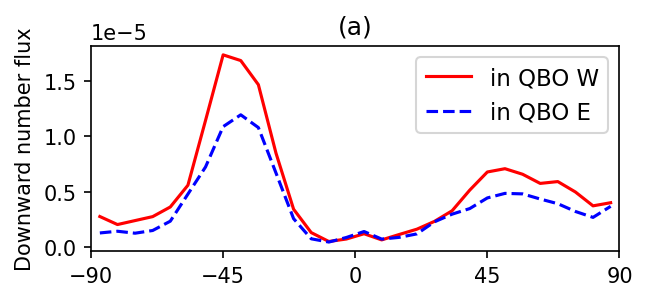

In [7]:
from copy import copy

iz = 2
i_mon1 = 0
i_mon2 = Total_Mon

fig = plt.figure(figsize=(10,4), dpi=150)
gs = gridspec.GridSpec(1, 10, figure=fig)
projection = crs.PlateCarree()

Num_min = -1.5e-5 
Num_max = 1.5e-5
# Num_min = -5
# Num_max = 5
extent = [-180 , 180 , 90 , -90]

###
###
# ax1 = fig.add_subplot(gs[0, 7:10])
ax1 = fig.add_subplot(2,2,1)

Sink_num_5yr_tmean = np.mean(Sink_num_5yr[:,:,:], axis=(2))
data_all = np.mean( Sink_num_5yr_tmean[:,:]/ Grid_area[:,:], axis=(1) )
data_W = np.mean( Sink_num_W[:,:]/ Grid_area[:,:], axis=(1) )
data_E = np.mean( Sink_num_E[:,:]/ Grid_area[:,:], axis=(1) )

# ax1.plot(data_all[:], Lats_mid, 'k-',  label="Annual")
ax1.plot(Lats_mid, data_W[:], 'r-', label="in QBO W")
# ax1.plot(data_MAM[:], Lats_mid, 'b--', label="MAM")
ax1.plot(Lats_mid, data_E[:], 'b--', label="in QBO E")
# ax1.plot(data_SON[:], Lats_mid, 'y--', label="SON")

ax1.set_xlim(-90,90)
ax1.set_xticks((-90,-45,0,45,90))
ax1.set_ylabel("Downward number flux")
# ax1.set_yticklabels(-90,-45,0,45,90)

# ax1.set_xlabel("Zonal mean of number flux", fontsize=11);
ax1.set_title("(a)");

ax1.legend(fontsize=11);
# plt.tight_layout()


# 2. Number concentration in the stratosphere

In [8]:
Years = ["2000","2001","2002","2003","2004","2005","2006","2007","2008","2009"]
N_year = len(Years)

Months = []
for imon in range(1,13): ### shw
    Months.append(str(imon).zfill(2))
    
Days = []
for iday in range(1,30,3):
    Days.append(str(iday).zfill(2))
    
print(Years)
print(Months)
print(Days)

['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009']
['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
['01', '04', '07', '10', '13', '16', '19', '22', '25', '28']


In [9]:
Lats_edge = np.arange(-90,91,6)
Lons_edge = np.arange(-180,181,10)

Lats_mid = np.arange(-87,90,6)
Lons_mid = np.arange(-175,180,10)

# Levs    = [100, 75, 65, 55, 40, 30]
# Heights = [16, 18, 19, 20, 22, 24]
Levs    = [100, 75, 65, 55, 47, 40, 30] # hPa
Heights = [16,  17.92, 18.87, 20, 21.05, 22.1, 24] # km
# [100, 75, 55, 40, 30]


N_lat = len(Lats_mid)
N_lon = len(Lons_mid)
N_lev = len(Levs) # 16, 18, 19, 20, 22, 24 km

Lats_edge, Lons_edge, Lats_mid, Lons_mid, N_lat, N_lon, Lons_edge[-1]

(array([-90, -84, -78, -72, -66, -60, -54, -48, -42, -36, -30, -24, -18,
        -12,  -6,   0,   6,  12,  18,  24,  30,  36,  42,  48,  54,  60,
         66,  72,  78,  84,  90]),
 array([-180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,  -80,
         -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,   30,
          40,   50,   60,   70,   80,   90,  100,  110,  120,  130,  140,
         150,  160,  170,  180]),
 array([-87, -81, -75, -69, -63, -57, -51, -45, -39, -33, -27, -21, -15,
         -9,  -3,   3,   9,  15,  21,  27,  33,  39,  45,  51,  57,  63,
         69,  75,  81,  87]),
 array([-175, -165, -155, -145, -135, -125, -115, -105,  -95,  -85,  -75,
         -65,  -55,  -45,  -35,  -25,  -15,   -5,    5,   15,   25,   35,
          45,   55,   65,   75,   85,   95,  105,  115,  125,  135,  145,
         155,  165,  175]),
 30,
 36,
 180)

In [10]:
# count the particle (injected at different height) number in each grid cell
N_day  = 20*366
Num_2D = np.zeros((N_lat, N_lon, N_lev, N_day)) 


for i_year in tqdm(range(N_year)):
    
    NUMs = np.zeros((N_lon*N_lat*N_day, N_lev))
    
    # total stratosphere
    File1 = open('/n/home12/hongwei/Paper_3_QBO/Particle_Number_Within_15deg/Num_Concnt_data/Num_Concnt_2000_'+Years[i_year]+'.txt', 'r')
    
    Lines1 = File1.readlines()
    
    ii = 0
    for line1 in Lines1:
        a1 = line1.split(',')
        NUMs[ii,0] = float(a1[3])
        NUMs[ii,1] = float(a1[4])
        NUMs[ii,2] = float(a1[5])
        NUMs[ii,3] = float(a1[6])
        NUMs[ii,5] = float(a1[7])
        NUMs[ii,6] = float(a1[8])
        ii = ii+1

        
#     # 21-km injection
#     File2 = open('/n/home12/hongwei/Paper_2/Plot_python/21km_post_process/Num_Concnt_21km/Num_Concnt_2000_'+Years[i_year]+'_21km.txt', 'r')
#     Lines2 = File2.readlines()
    
#     ii = 0
#     for line2 in Lines2:
#         a2 = line2.split(',')
#         NUMs[ii,4] = float(a2[3])
#         ii = ii+1        

        
    # remap to global (Lon,Lat) mesh
    Num_2D_temp = np.zeros((N_lat, N_lon, N_lev, N_day)) 
    for i_day in range(N_day):
        for ix in range(N_lon):
            for iy in range(N_lat):
                ii = i_day*(N_lat*N_lon) + ix*N_lat + iy
                Num_2D_temp[iy, ix, :, i_day] = NUMs[ii,:]
               
            
    Num_2D = Num_2D + Num_2D_temp            
    
print(ii)

100%|██████████| 10/10 [06:32<00:00, 39.25s/it]

7905599


In [11]:

i_day1 = 5*365
i_day2 = 10365

Num_19km = Num_2D[:,:,2,i_day1:i_day2]

###

time_lag = 4*30

it_w1 = 30*0 +time_lag
it_w2 = 30*4 +time_lag

it_w3 = 365*2 +time_lag
it_w4 = 365*2 +30*4 +time_lag

it_w5 = 365*4 +time_lag
it_w6 = 364*4 +30*4 +time_lag

N_day_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1

Num_W = ( np.sum(Num_19km[:,:,it_w1:it_w2], axis=2) + np.sum(Num_19km[:,:,it_w3:it_w4], axis=2) + np.sum(Num_19km[:,:,it_w5:it_w6], axis=2) ) / N_day_W

###
it_e1 = 365*1 +time_lag
it_e2 = 365*1 +30*4 +time_lag

it_e3 = 365*3 +time_lag
it_e4 = 365*3 +30*4 +time_lag

N_day_E = it_e4-it_e3 + it_e2-it_e1

Num_E = ( np.sum(Num_19km[:,:,it_e1:it_e2], axis=2) + np.sum(Num_19km[:,:,it_e3:it_e4], axis=2) ) / N_day_E

Num_E.shape

(30, 36)

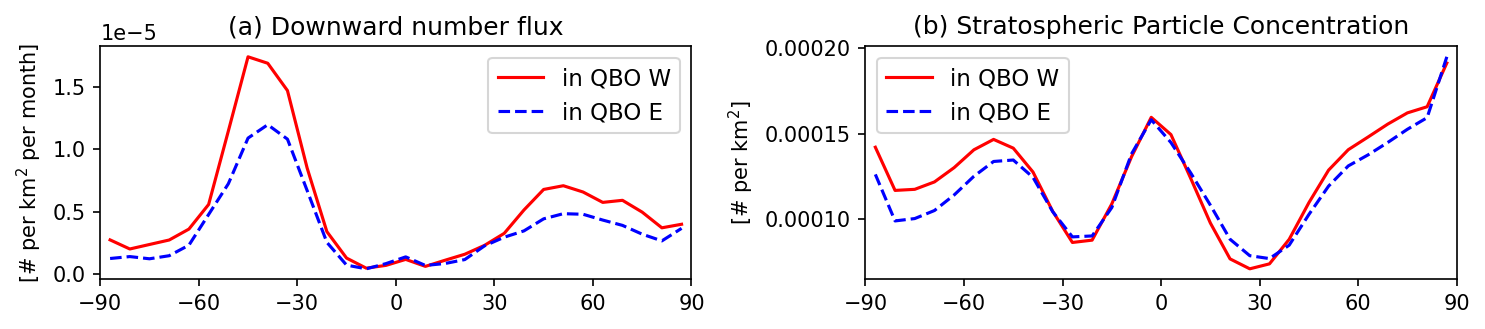

In [12]:
fig = plt.figure(figsize=(10,4), dpi=150)

###
ax1 = fig.add_subplot(2,2,1)

Sink_num_5yr_tmean = np.mean(Sink_num_5yr[:,:,:], axis=(2))
data_all = np.mean( Sink_num_5yr_tmean[:,:]/ Grid_area[:,:], axis=(1) )
data_W = np.mean( Sink_num_W[:,:]/ Grid_area[:,:], axis=(1) )
data_E = np.mean( Sink_num_E[:,:]/ Grid_area[:,:], axis=(1) )

ax1.plot(Lats_mid, data_W[:], 'r-', label="in QBO W")
ax1.plot(Lats_mid, data_E[:], 'b--', label="in QBO E")

ax1.set_xlim(-90,90)
ax1.set_xticks((-90,-60,-30,0,30,60,90))
ax1.set_ylabel("[# per km$^2$ per month]")
# ax1.set_yticklabels(-90,-45,0,45,90)

# ax1.set_xlabel("Zonal mean of number flux", fontsize=11);
ax1.set_title("(a) Downward number flux");

ax1.legend(fontsize=11);


###
ax2 = fig.add_subplot(2,2,2)

NUM_W = np.mean( Num_W[:,:]/ Grid_area[:,:], axis=(1) )
NUM_E = np.mean( Num_E[:,:]/ Grid_area[:,:], axis=(1) )

ax2.plot(Lats_mid, NUM_W[:], 'r-', label="in QBO W")
ax2.plot(Lats_mid, NUM_E[:], 'b--', label="in QBO E")

ax2.set_xlim(-90,90)
ax2.set_xticks((-90,-60,-30,0,30,60,90))
ax2.set_ylabel("[# per km$^2$]")
# ax2.set_yticklabels(-90,-45,0,45,90)

# ax2.set_xlabel("Zonal mean of number flux", fontsize=11);
ax2.set_title("(b) Stratospheric Particle Concentration");
ax2.legend(fontsize=11);


plt.tight_layout()

# 3. tropopause folding frequency

In [13]:
ds = xr.open_dataset('/n/home12/hongwei/HONGWEI/Tropopause/ERA5low_wmo_2nd_z_2005-2009_daymean.nc')

time = ds['time']
lon = ds['lon']
lat = ds['lat']

Nt = len(time)
Nx = len(lon)
Ny = len(lat)

Double_Tropo = ds['wmo_2nd_z']

DT_freq = Double_Tropo/Double_Tropo

In [14]:
# there is a 7-month time lag

time_lag = 7*30

it_w1 = 0+time_lag
it_w2 = 4*30+time_lag

it_w3 = 365*2+time_lag
it_w4 = 365*2+4*30+time_lag

it_w5 = 365*4+time_lag
it_w6 = 365*4+4*30+time_lag

N_day_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1

DT_freq_W1 = np.nansum(DT_freq[it_w1:it_w2,:,:], axis=0)
DT_freq_W2 = np.nansum(DT_freq[it_w3:it_w4,:,:], axis=0)
DT_freq_W3 = np.nansum(DT_freq[it_w5:it_w6,:,:], axis=0)

DT_freq_West = (DT_freq_W1+DT_freq_W2+DT_freq_W3) / N_day_W


###
it_e1 = 365*1+time_lag
it_e2 = 365*1+4*30+time_lag

it_e3 = 365*3+time_lag
it_e4 = 365*3+4*30+time_lag

N_day_E = it_e4-it_e3 + it_e2-it_e1

DT_freq_E1 = np.nansum(DT_freq[it_e1:it_e2,:,:], axis=0)
DT_freq_E2 = np.nansum(DT_freq[it_e3:it_e4,:,:], axis=0)

DT_freq_East = (DT_freq_E1+DT_freq_E2) / N_day_E

In [15]:
DT_freq_West_Xmean = np.nanmean(DT_freq_West, axis=1)
DT_freq_East_Xmean = np.nanmean(DT_freq_East, axis=1)

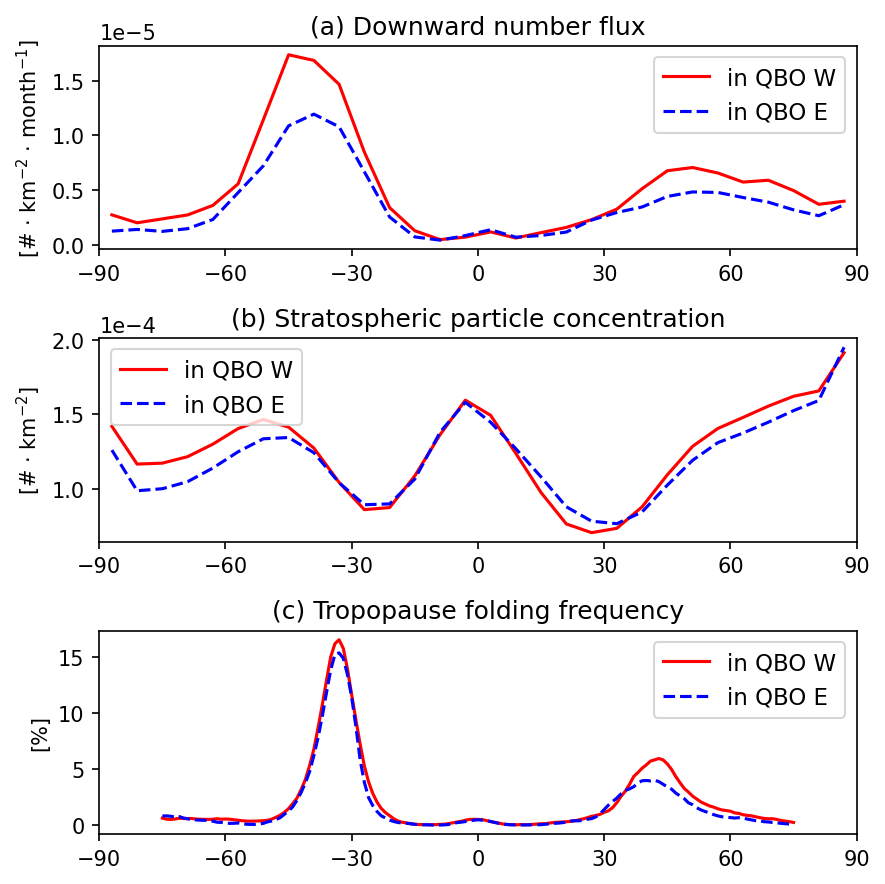

In [16]:
fig = plt.figure(figsize=(6,6), dpi=350)

###
ax1 = fig.add_subplot(3,1,1)

Sink_num_5yr_tmean = np.mean(Sink_num_5yr[:,:,:], axis=(2))
data_all = np.mean( Sink_num_5yr_tmean[:,:]/ Grid_area[:,:], axis=(1) )
data_W = np.mean( Sink_num_W[:,:]/ Grid_area[:,:], axis=(1) )
data_E = np.mean( Sink_num_E[:,:]/ Grid_area[:,:], axis=(1) )

ax1.plot(Lats_mid, data_W[:], 'r-', label="in QBO W")
ax1.plot(Lats_mid, data_E[:], 'b--', label="in QBO E")

ax1.set_xlim(-90,90)
ax1.set_xticks((-90,-60,-30,0,30,60,90))
ax1.set_ylabel("[# $\cdot$ km$^{-2}$ $\cdot$ month$^{-1}$]")
# ax1.set_yticklabels(-90,-45,0,45,90)

# ax1.set_xlabel("Zonal mean of number flux", fontsize=11);
ax1.set_title("(a) Downward number flux");

ax1.legend(fontsize=11);


###
ax2 = fig.add_subplot(3,1,2)

NUM_W = np.mean( Num_W[:,:]/ Grid_area[:,:], axis=(1) )
NUM_E = np.mean( Num_E[:,:]/ Grid_area[:,:], axis=(1) )

ax2.plot(Lats_mid, NUM_W[:], 'r-', label="in QBO W")
ax2.plot(Lats_mid, NUM_E[:], 'b--', label="in QBO E")

ax2.set_xlim(-90,90)
ax2.set_xticks((-90,-60,-30,0,30,60,90))
ax2.set_ylabel("[# $\cdot$ km$^{-2}$]")
# ax2.set_yticklabels(-90,-45,0,45,90)
# ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1e}"))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# ax2.set_xlabel("Zonal mean of number flux", fontsize=11);
ax2.set_title("(b) Stratospheric particle concentration");
ax2.legend(fontsize=11);


###
ax3 = fig.add_subplot(3,1,3)

iy1=15
iy2=-15

ax3.plot(lat[iy1:iy2], 100*DT_freq_West_Xmean[iy1:iy2], 'r-', label="in QBO W")
ax3.plot(lat[iy1:iy2], 100*DT_freq_East_Xmean[iy1:iy2], 'b--', label="in QBO E")

# ax3.set_yscale('log')
ax3.set_xlim(-90,90)
ax3.set_xticks((-90,-60,-30,0,30,60,90))
ax3.set_ylabel("[%]")
# ax2.set_yticklabels(-90,-45,0,45,90)

# ax2.set_xlabel("Zonal mean of number flux", fontsize=11);
ax3.set_title("(c) Tropopause folding frequency");
ax3.legend(fontsize=11);


plt.tight_layout()

In [17]:
Sink_num_W_Xsum = np.sum(Sink_num_W, axis=1)/6 # [# per deg per month]
Sink_num_E_Xsum = np.sum(Sink_num_E, axis=1)/6

NUM_W_Xsum = np.sum(Num_W, axis=1)/6 # [#/deg]
NUM_E_Xsum = np.sum(Num_E, axis=1)/6 


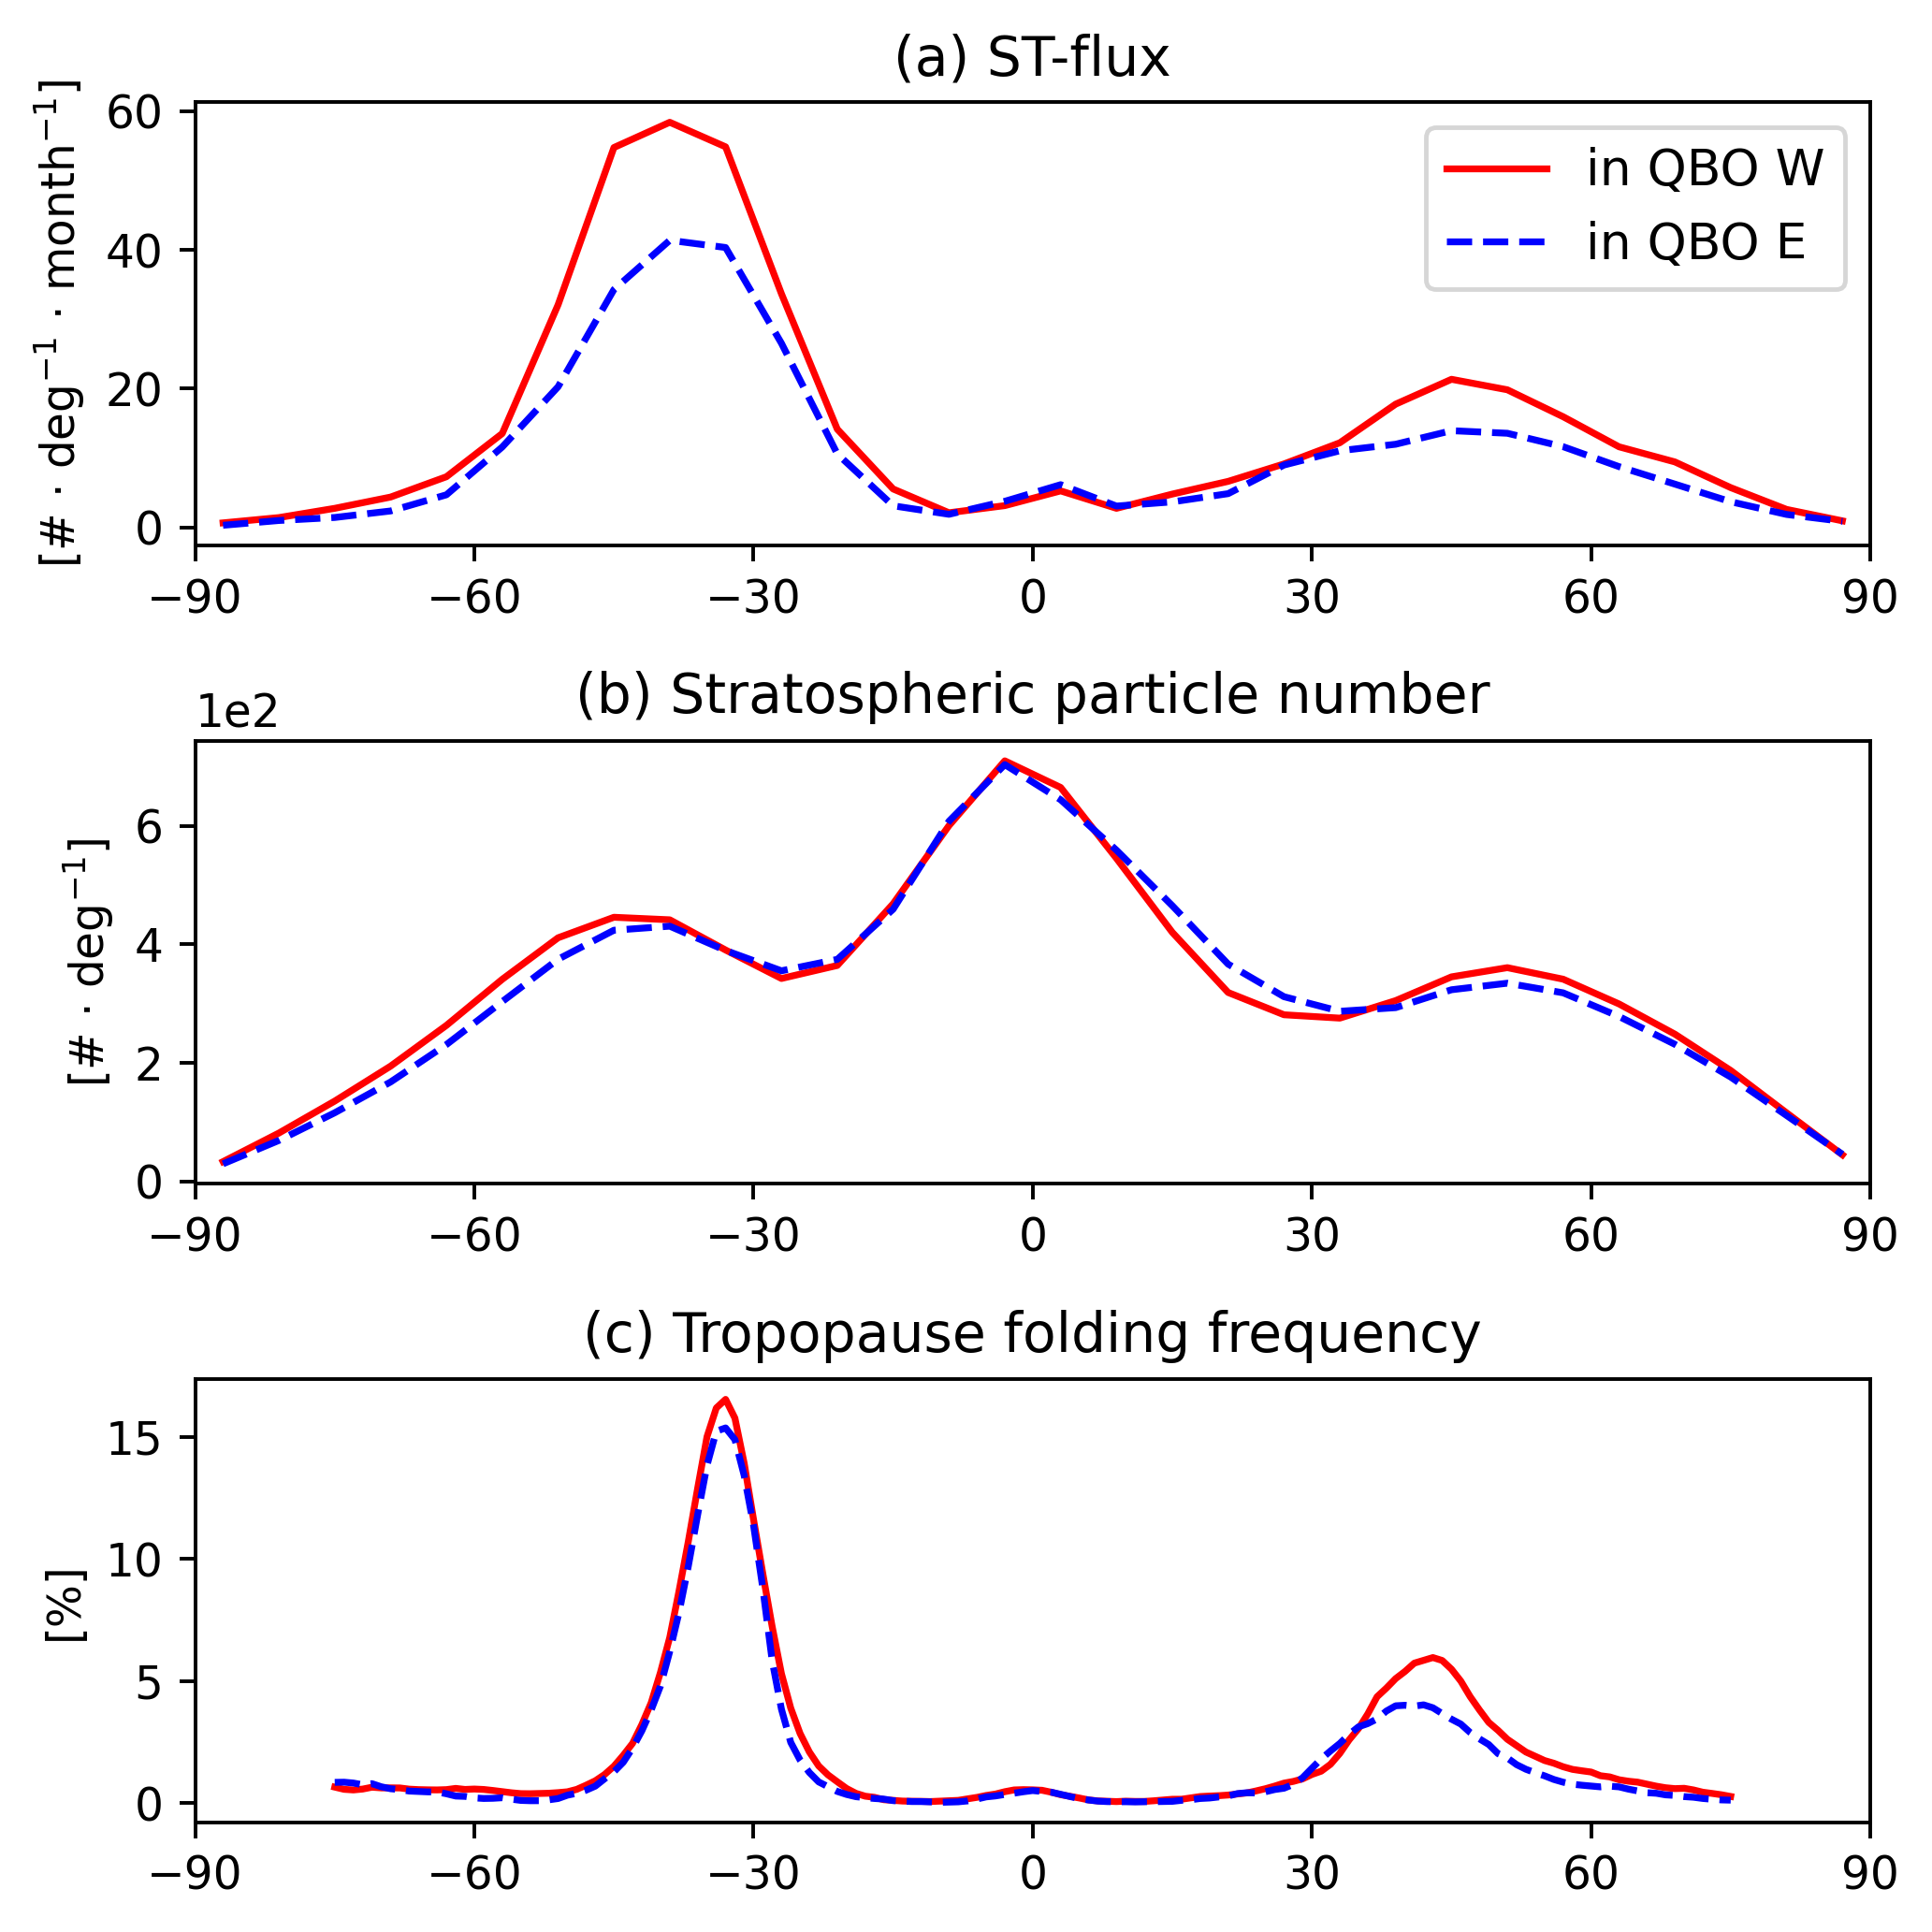

In [26]:
fig = plt.figure(figsize=(6,6), dpi=350)

###
ax1 = fig.add_subplot(3,1,1)

ax1.plot(Lats_mid, Sink_num_W_Xsum[:], 'r-', label="in QBO W")
ax1.plot(Lats_mid, Sink_num_E_Xsum[:], 'b--', label="in QBO E")

ax1.set_xlim(-90,90)
ax1.set_xticks((-90,-60,-30,0,30,60,90))
ax1.set_ylabel("[# $\cdot$ deg$^{-1}$ $\cdot$ month$^{-1}$]")
# ax1.set_yticklabels(-90,-45,0,45,90)

# ax1.set_xlabel("Zonal mean of number flux", fontsize=11);
ax1.set_title("(a) ST-flux");

ax1.legend(fontsize=11);


###
ax2 = fig.add_subplot(3,1,2)

ax2.plot(Lats_mid, NUM_W_Xsum[:], 'r-', label="in QBO W")
ax2.plot(Lats_mid, NUM_E_Xsum[:], 'b--', label="in QBO E")

# ax2.set_yscale('log')

ax2.set_xlim(-90,90)
ax2.set_xticks((-90,-60,-30,0,30,60,90))
ax2.set_ylabel("[# $\cdot$ deg$^{-1}$]")
# ax2.set_yticklabels(-90,-45,0,45,90)
# ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1e}"))
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# ax2.set_xlabel("Zonal mean of number flux", fontsize=11);
ax2.set_title("(b) Stratospheric particle number");
# ax2.legend(fontsize=11);


###
ax3 = fig.add_subplot(3,1,3)

iy1=15
iy2=-15

ax3.plot(lat[iy1:iy2], 100*DT_freq_West_Xmean[iy1:iy2], 'r-', label="in QBO W")
ax3.plot(lat[iy1:iy2], 100*DT_freq_East_Xmean[iy1:iy2], 'b--', label="in QBO E")

# ax3.set_yscale('log')
ax3.set_xlim(-90,90)
ax3.set_xticks((-90,-60,-30,0,30,60,90))
ax3.set_ylabel("[%]")
# ax2.set_yticklabels(-90,-45,0,45,90)

# ax2.set_xlabel("Zonal mean of number flux", fontsize=11);
ax3.set_title("(c) Tropopause folding frequency");
# ax3.legend(fontsize=11);


plt.tight_layout()
plt.savefig("Figure_3.jpg")

# !!! Stop here !!!

# 4. tropopause height: ignore this

In [19]:
ds = xr.open_dataset('/n/home12/hongwei/HONGWEI/Tropopause/ERA5low_2005-2009_daymean_Tropopause_Height.nc')

time = ds['time']
lon = ds['lon']
lat = ds['lat']

Nt = len(time)
Nx = len(lon)
Ny = len(lat)

dyn_p = ds['dyn_p']
wmo_1st_p = ds['wmo_1st_p']

In [20]:
Tropopause = np.maximum(dyn_p, wmo_1st_p) # higher pressure means lower altitude!!!!

In [21]:
# there is a 7-month time lag

time_lag = 7*30

it_w1 = 0+time_lag
it_w2 = 4*30+time_lag

it_w3 = 365*2+time_lag
it_w4 = 365*2+4*30+time_lag

it_w5 = 365*4+time_lag
it_w6 = 365*4+4*30+time_lag

N_day_W = it_w6-it_w5 + it_w4-it_w3 + it_w2-it_w1

Tropopause_W1 = np.nansum(Tropopause[it_w1:it_w2,:,:], axis=0)
Tropopause_W2 = np.nansum(Tropopause[it_w3:it_w4,:,:], axis=0)
Tropopause_W3 = np.nansum(Tropopause[it_w5:it_w6,:,:], axis=0)

Tropopause_West = (Tropopause_W1+Tropopause_W2+Tropopause_W3) / N_day_W


###
it_e1 = 365*1+time_lag
it_e2 = 365*1+4*30+time_lag

it_e3 = 365*3+time_lag
it_e4 = 365*3+4*30+time_lag

N_day_E = it_e4-it_e3 + it_e2-it_e1

Tropopause_E1 = np.nansum(Tropopause[it_e1:it_e2,:,:], axis=0)
Tropopause_E2 = np.nansum(Tropopause[it_e3:it_e4,:,:], axis=0)

Tropopause_East = (Tropopause_E1+Tropopause_E2) / N_day_E


In [22]:
Tropopause_West_Xmean = np.nanmean(Tropopause_West, axis=1)
Tropopause_East_Xmean = np.nanmean(Tropopause_East, axis=1)

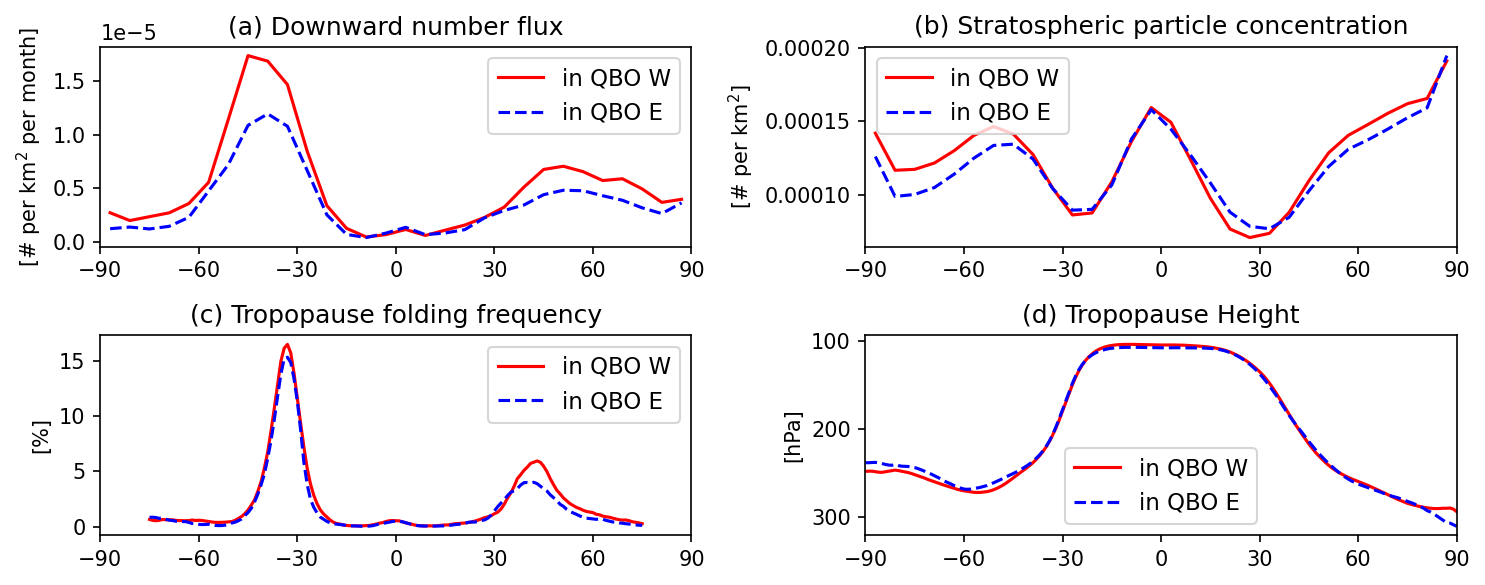

In [23]:
fig = plt.figure(figsize=(10,4), dpi=150)

###
ax1 = fig.add_subplot(2,2,1)

Sink_num_5yr_tmean = np.mean(Sink_num_5yr[:,:,:], axis=(2))
data_all = np.mean( Sink_num_5yr_tmean[:,:]/ Grid_area[:,:], axis=(1) )
data_W = np.mean( Sink_num_W[:,:]/ Grid_area[:,:], axis=(1) )
data_E = np.mean( Sink_num_E[:,:]/ Grid_area[:,:], axis=(1) )

ax1.plot(Lats_mid, data_W[:], 'r-', label="in QBO W")
ax1.plot(Lats_mid, data_E[:], 'b--', label="in QBO E")

ax1.set_xlim(-90,90)
ax1.set_xticks((-90,-60,-30,0,30,60,90))
ax1.set_ylabel("[# per km$^2$ per month]")
# ax1.set_yticklabels(-90,-45,0,45,90)

# ax1.set_xlabel("Zonal mean of number flux", fontsize=11);
ax1.set_title("(a) Downward number flux");

ax1.legend(fontsize=11);

###
ax2 = fig.add_subplot(2,2,2)

NUM_W = np.mean( Num_W[:,:]/ Grid_area[:,:], axis=(1) )
NUM_E = np.mean( Num_E[:,:]/ Grid_area[:,:], axis=(1) )

ax2.plot(Lats_mid, NUM_W[:], 'r-', label="in QBO W")
ax2.plot(Lats_mid, NUM_E[:], 'b--', label="in QBO E")

ax2.set_xlim(-90,90)
ax2.set_xticks((-90,-60,-30,0,30,60,90))
ax2.set_ylabel("[# per km$^2$]")
# ax2.set_yticklabels(-90,-45,0,45,90)

# ax2.set_xlabel("Zonal mean of number flux", fontsize=11);
ax2.set_title("(b) Stratospheric particle concentration");
ax2.legend(fontsize=11);


###
ax3 = fig.add_subplot(2,2,3)

iy1=15
iy2=-15

ax3.plot(lat[iy1:iy2], 100*DT_freq_West_Xmean[iy1:iy2], 'r-', label="in QBO W")
ax3.plot(lat[iy1:iy2], 100*DT_freq_East_Xmean[iy1:iy2], 'b--', label="in QBO E")

# ax3.set_yscale('log')
ax3.set_xlim(-90,90)
ax3.set_xticks((-90,-60,-30,0,30,60,90))
ax3.set_ylabel("[%]")
# ax2.set_yticklabels(-90,-45,0,45,90)

# ax2.set_xlabel("Zonal mean of number flux", fontsize=11);
ax3.set_title("(c) Tropopause folding frequency");
ax3.legend(fontsize=11);


##
ax4 = fig.add_subplot(2,2,4)

ax4.plot(lat, Tropopause_West_Xmean, 'r-', label="in QBO W")
ax4.plot(lat, Tropopause_East_Xmean, 'b--', label="in QBO E")

# ax4.set_yscale('log')
# ax4.set_ylim(-10,10)
ax4.set_xlim(-90,90)
ax4.set_xticks((-90,-60,-30,0,30,60,90))
ax4.set_ylabel("[hPa]")
# ax4.set_yticklabels(-90,-45,0,45,90)
plt.gca().invert_yaxis()

# ax4.set_xlabel("Zonal mean of number flux", fontsize=11);
ax4.set_title("(d) Tropopause Height");
ax4.legend(fontsize=11);


plt.tight_layout()